# Complex and noisy Bayesian optimization

This notebook is only here to illustrate how Bayesian optimization may be used on more complex use cases with a true behavior more difficult to approximate, both more complex and noisy (see `true_function`).

Refer to the other notebook to get the full explanation (`bayesian_optimization.ipynb`).

In [1]:
import numpy as np
np.random.seed(2018)

from skopt import Optimizer

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [2]:
search_space = {
    'param_1': (0.0, 25.0),
    'param_2': (0.0, 25.0)
}

In [3]:
x_graph = np.arange(search_space['param_1'][0], search_space['param_1'][1], 0.5)
y_graph = np.arange(search_space['param_2'][0], search_space['param_2'][1], 0.5)

X, Y = np.meshgrid(x_graph, y_graph)

## Mocking the behavior of the database

In [4]:
NOISE_LEVEL = 0.05

def true_function(x, noise_level=NOISE_LEVEL):
    y = np.cos(x[0] / 5) * np.sin(x[1] / 5) + x[1] / 25 + 1 + np.random.randn() * noise_level
    return y

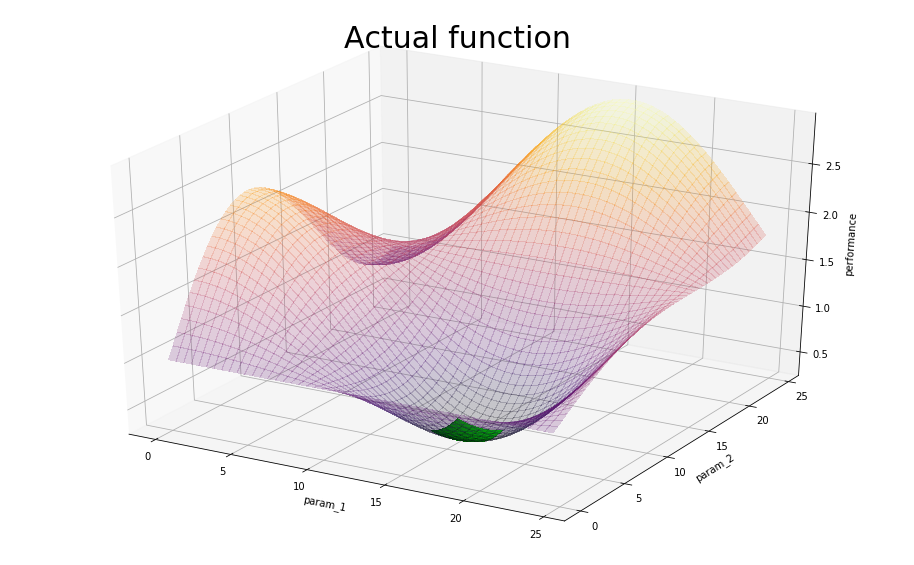

In [5]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Actual function', fontdict={'size':30})

# Plotting without noise_level to visualize smooth function
z_graph = np.array([true_function([x, y], noise_level=0) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = z_graph.reshape(X.shape)

# Defining surface around the minimum for visualization purposes
x_minimum_graph = np.arange(14, 17, 0.1)
y_minimum_graph = np.arange(5, 8, 0.1)

X_min, Y_min = np.meshgrid(x_minimum_graph, y_minimum_graph)

z_minimum_graph = np.array([true_function([x, y], noise_level=0) for x, y in zip(np.ravel(X_min), np.ravel(Y_min))])
Z_min = z_minimum_graph.reshape(X_min.shape)

ax.set_xlabel('param_1')
ax.set_ylabel('param_2')
ax.set_zlabel('performance')
ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.2)
ax.plot_surface(X_min, Y_min, Z_min, color='#00FF00', linewidth=0, antialiased=False, alpha=1)

## Running the optimization

In [6]:
opt = Optimizer([search_space['param_1'], search_space['param_2']], 
                "GP", 
                n_initial_points=5)

In [7]:
for _ in range(5):
    # What value should we test next?
    next_x = opt.ask()
    
    # Here we call true_function(next_x) to get the value of our observation
    # In practice we would have to run a benchmark to get the performance
    f_val = true_function(next_x)
    
    print('Set of parameters tested: {{param_1: {}, param_2: {}}} - '
          'Performance: {}s'.format(round(next_x[0], 3),
                                    round(next_x[1], 3),
                                    round(f_val, 3)))
    
    opt.tell(next_x, f_val)

Set of parameters tested: {param_1: 11.747, param_2: 19.409} - Performance: 2.306s
Set of parameters tested: {param_1: 18.375, param_2: 11.144} - Performance: 0.783s
Set of parameters tested: {param_1: 0.264, param_2: 17.713} - Performance: 1.352s
Set of parameters tested: {param_1: 21.286, param_2: 24.352} - Performance: 2.41s
Set of parameters tested: {param_1: 1.472, param_2: 7.589} - Performance: 2.299s


In [8]:
def plot_optimizer(opt, iteration, next_value):
    # Extracting the sklearn GaussianProcessRegressor model to help us visualize
    model = opt.models[-1]
    
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title('Bayesian optimization after {} iterations \n'
                 'Next value to test: ({}, {})'.format(iteration, 
                                                       next_value[0], 
                                                       next_value[1]), 
                 fontdict={'size': 20})
        
    # Data should be normalized to be used in skopt.Optimizer (see documentation about skopt.Space)
    # One way to do it is to use Space.transform(), the target warped space can be achieved 
    # through simple normalization here
    z_graph = np.array([model.predict(np.array([x, y]).reshape(1, -1)) for x, y in zip(np.ravel(X / 25), np.ravel(Y / 25))])
    Z = z_graph.reshape(X.shape)

    ax.set_xlabel('param_1')
    ax.set_ylabel('param_2')
    ax.set_zlabel('performance')
    
    # Plotting the GaussianProcess mean estimation
    ax.plot_surface(X, Y, Z, cmap=cm.inferno, linewidth=0, antialiased=False, alpha=0.5)
    
    # Plotting the actual observations
    ax.scatter(xs=[x[0] for x in opt.Xi],
               ys=[x[1] for x in opt.Xi],
               zs=opt.yi, 
               c='r', 
               marker='o',
               s=15**2)

5 - Set of parameters tested: {param_1: 18.367, param_2: 11.089} - Performance: 0.739s
6 - Set of parameters tested: {param_1: 18.312, param_2: 10.672} - Performance: 0.676s
7 - Set of parameters tested: {param_1: 18.237, param_2: 10.119} - Performance: 0.498s
8 - Set of parameters tested: {param_1: 18.642, param_2: 6.966} - Performance: 0.526s
9 - Set of parameters tested: {param_1: 18.241, param_2: 9.208} - Performance: 0.437s
10 - Set of parameters tested: {param_1: 18.135, param_2: 8.348} - Performance: 0.475s
11 - Set of parameters tested: {param_1: 19.274, param_2: 8.886} - Performance: 0.552s
12 - Set of parameters tested: {param_1: 17.323, param_2: 9.051} - Performance: 0.432s
13 - Set of parameters tested: {param_1: 17.154, param_2: 9.024} - Performance: 0.348s
14 - Set of parameters tested: {param_1: 15.684, param_2: 8.75} - Performance: 0.435s
15 - Set of parameters tested: {param_1: 22.616, param_2: 0.0} - Performance: 0.998s


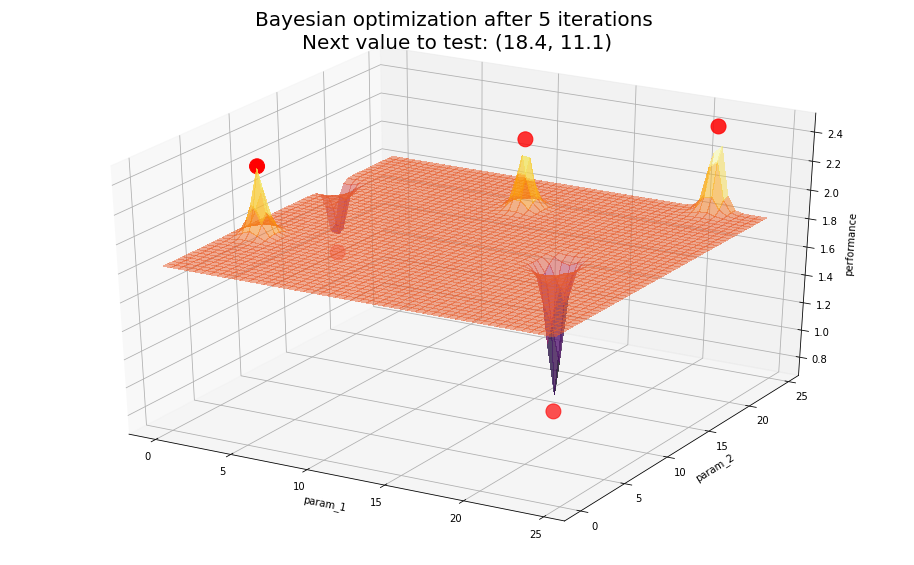

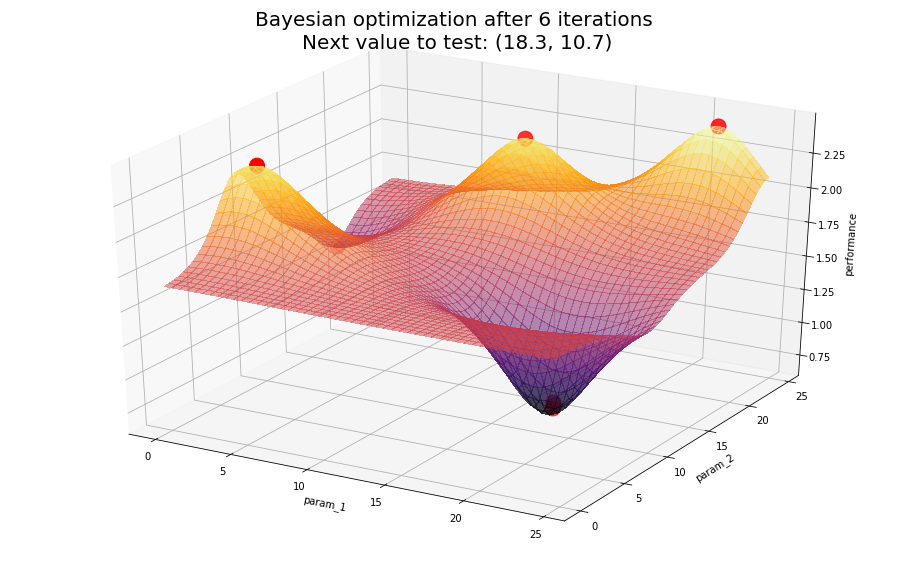

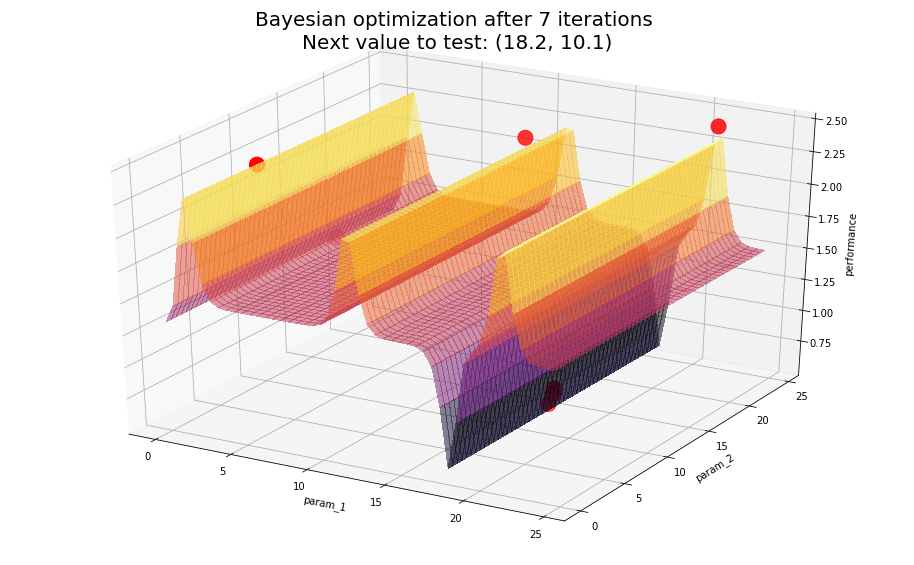

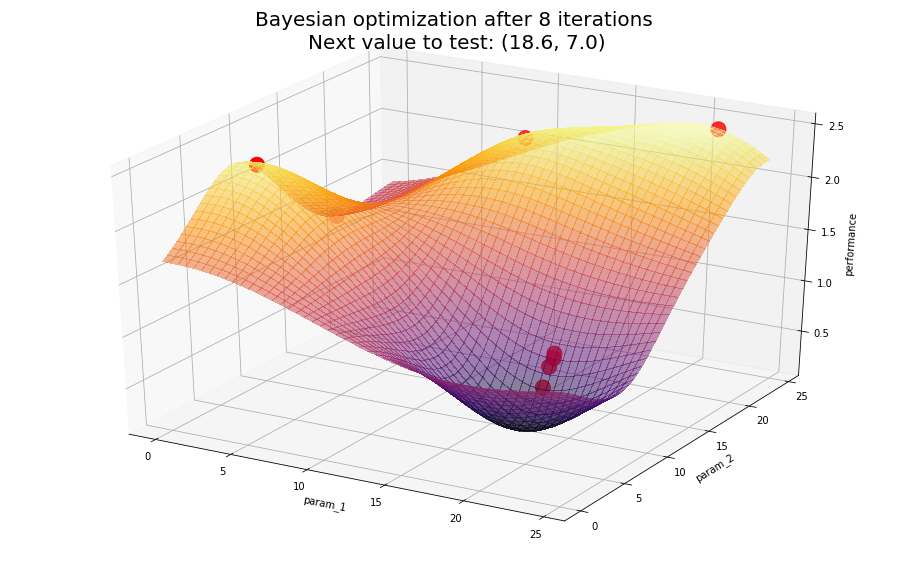

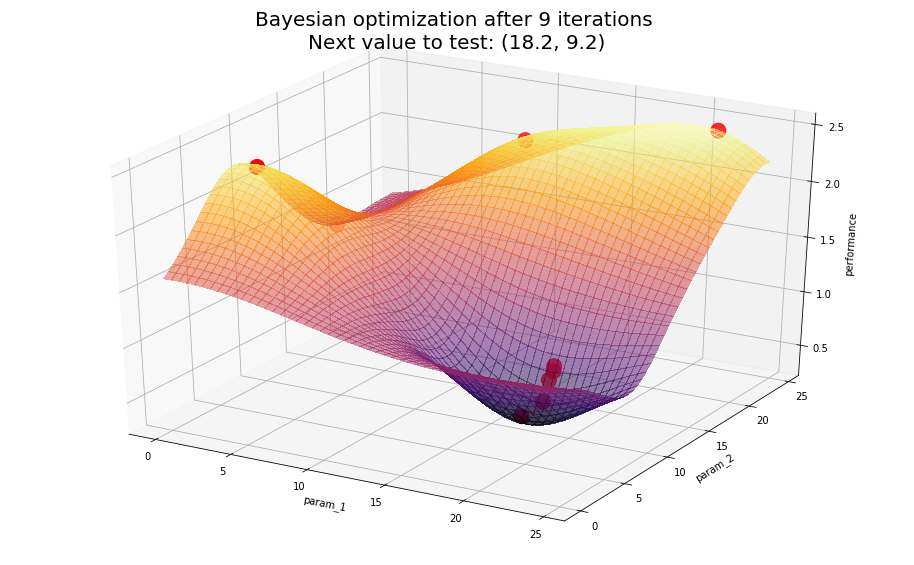

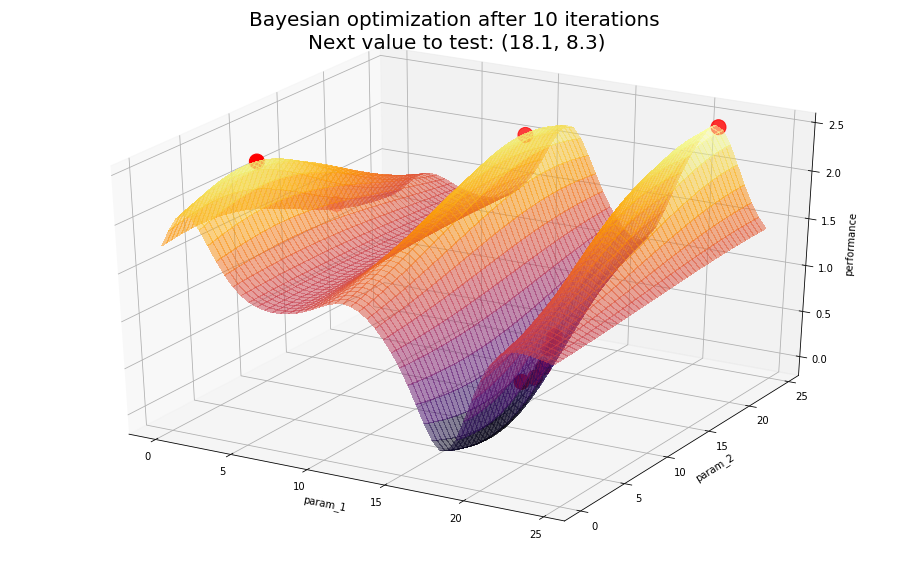

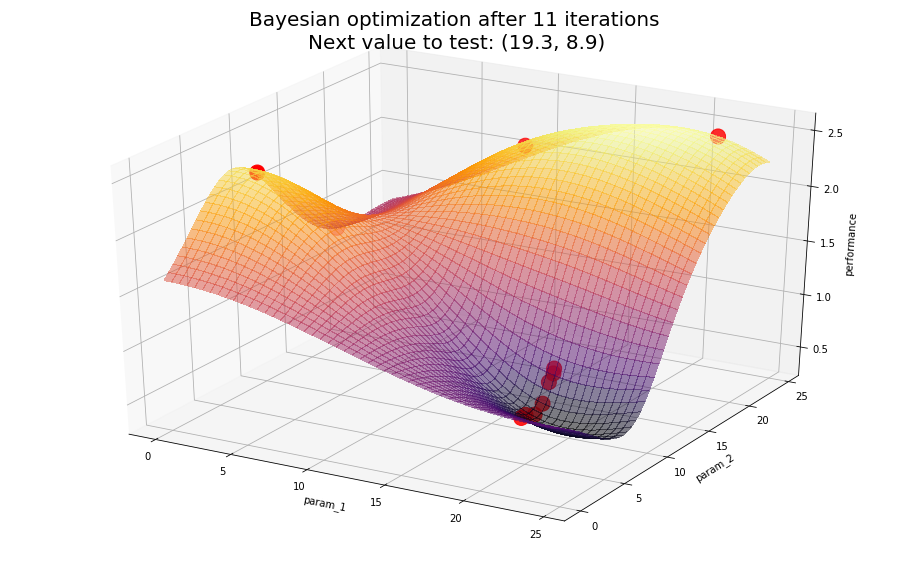

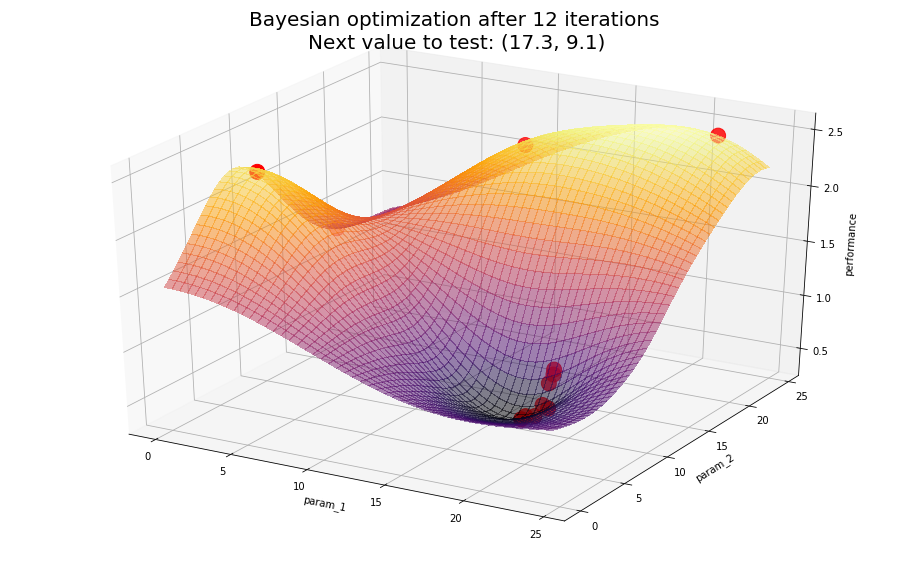

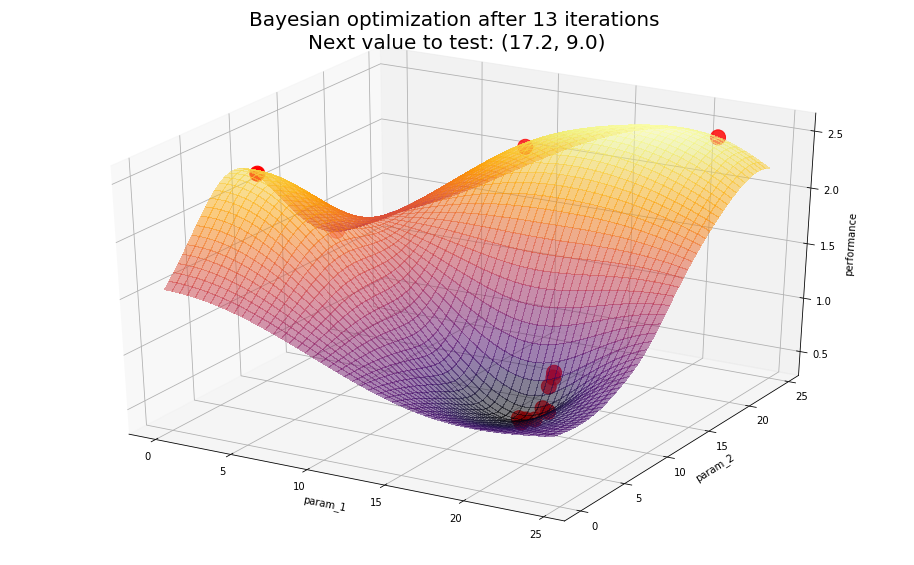

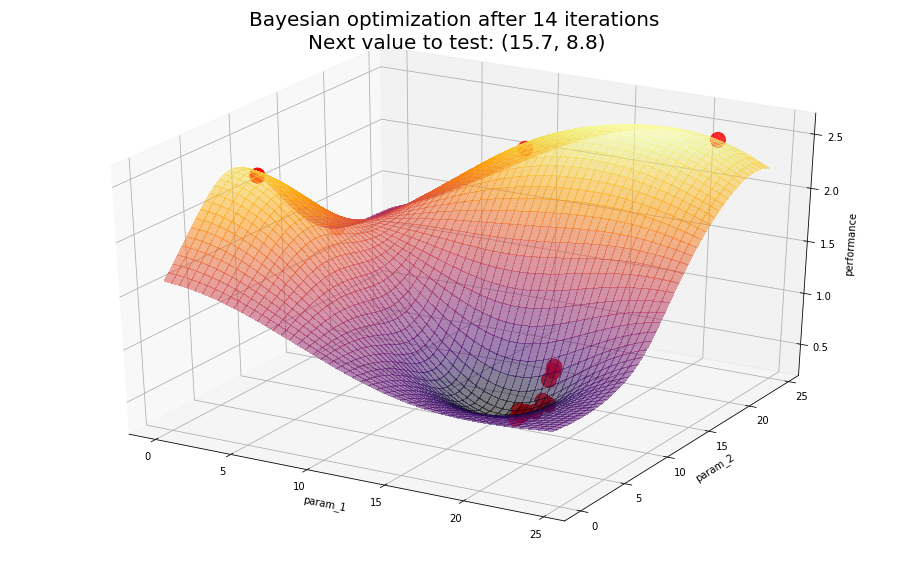

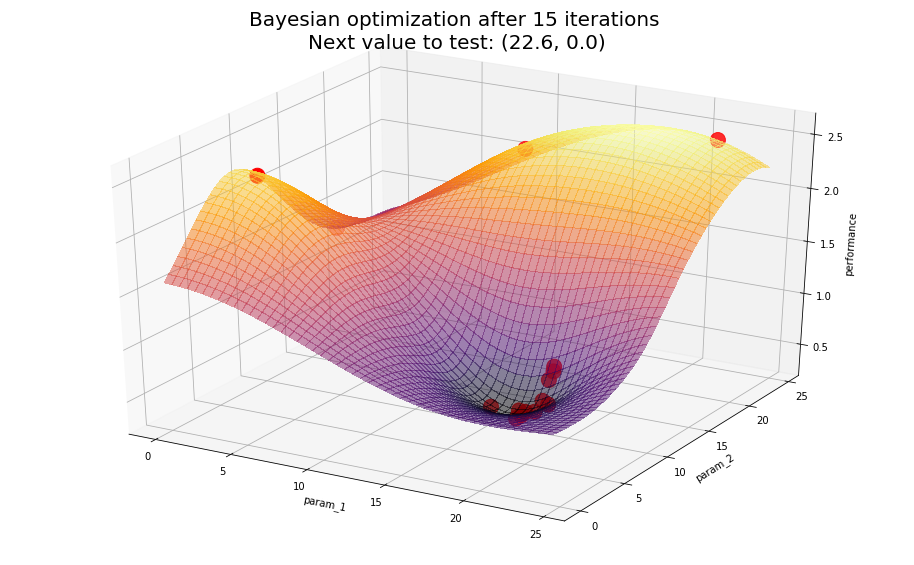

In [9]:
for iteration in range(5, 16):
    next_x = opt.ask()
    plot_optimizer(opt, iteration, np.round(next_x, 1))
    
    # Again, this would translate in a benchmark to get the true value
    f_val = true_function(next_x)
    print('{} - Set of parameters tested: {{param_1: {}, param_2: {}}} - '
          'Performance: {}s'.format(iteration,
                                    round(next_x[0], 3),
                                    round(next_x[1], 3),
                                    round(f_val, 3)))
    
    opt.tell(next_x, f_val)